In [1]:
# Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xlwt 
from xlwt import Workbook 
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

print('Libraries Loaded')

Libraries Loaded


In [2]:
## Utilities 

def read_file(path):
    df= pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    print(df.shape)
    print(df.head())
    return df

def create_dataset(X, y, time_steps, ts_range):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - ts_range):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.values[(i + time_steps):(i + time_steps + ts_range),0])
    return np.array(Xs), np.array(ys)

def splitter(df,output,lag,duration,ts):
    assert (0. <= ts <= 1.)
    train_size = int(len(df) * ts)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df[train_size:]
    print(train.shape, test.shape)
    scaler,scaler_single = MinMaxScaler(feature_range=(0, 1)),MinMaxScaler(feature_range=(0, 1))

    scaler.fit(train)
    scaler_single.fit(train[output])

    train_scaled = pd.DataFrame(scaler.transform(train), columns=[df.columns])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=[df.columns])

    df_train = train_scaled.copy(deep=True)
    df_test = test_scaled.copy(deep=True)

    x_train,y_train = create_dataset(df_train,df_train[[output]],lag,duration)
    x_test, y_test = create_dataset(df_test, df_test[[output]], lag, duration)

    return x_train,x_test,y_train,y_test,scaler_single

class attention(keras.layers.Layer):
    '''
    if return_sequences=True, it will give 3D vector and if false it will give 2D vector. It is same as LSTMs.

    https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
    the  following code is being copied from the above link.
    '''

    def __init__(self, return_sequences=True, **kwargs):
        self.return_sequences = return_sequences
        super(attention, self).__init__()

    def get_config(self):
        cfg = super().get_config()
        return cfg

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)

In [3]:
## Loading the file 

src = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Data'
filename = r'Pave_data_cleaned.xlsx'

dest = r'C:\Users\Saad.LAKES\Desktop\Pavement-Temperature-Prediction\Solutions'

df = read_file(os.path.join(src,filename))

(10896, 7)
   Year  Month  Day  Hour  Temp  Solar  Pavement
0  2009     11    1     1   8.4    0.0  9.333333
1  2009     11    1     2   8.3    0.0  8.933333
2  2009     11    1     3   7.9    0.0  8.700000
3  2009     11    1     4   7.6    0.0  8.533333
4  2009     11    1     5   6.9    0.0  8.533333


In [4]:
## Training the training and testing data

x_train,x_test,y_train,y_test,scaler = splitter(df[['Temp','Pavement']],['Pavement'],24,6,0.8)
print(f'The shape of x_train is {x_train.shape} and x_test is {x_test.shape}')
print(f'The shape of y_train is {y_train.shape} and y_test is {y_test.shape}')

(8716, 2) (2180, 2)
The shape of x_train is (8686, 24, 2) and x_test is (2150, 24, 2)
The shape of y_train is (8686, 6) and y_test is (2150, 6)


## LSTM Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_lstm.hdf5'
filepath_attention = 'attention_lstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
## Simple LSTM
K.clear_session()
simple_lstm = keras.Sequential()
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_lstm.add(keras.layers.Flatten())
simple_lstm.add(keras.layers.Dense(512, activation='relu'))
simple_lstm.add(keras.layers.Dense(128, activation='relu'))
simple_lstm.add(keras.layers.Dense(64, activation='relu'))
simple_lstm.add(keras.layers.Dropout(0.3))
simple_lstm.add(keras.layers.Dense(32))
simple_lstm.add(keras.layers.Dense(6))

simple_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

In [7]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

# history = simple_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

simple_lstm.load_weights(filepath_simple)
preds = simple_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
The Mean Squared Error is: 5.831630519312005


In [13]:
## Attention model

K.clear_session()
atten_lstm = keras.Sequential()
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
# atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_lstm.add(attention(return_sequences=True))
atten_lstm.add(keras.layers.Flatten())
atten_lstm.add(keras.layers.Dense(512, activation='relu'))
atten_lstm.add(keras.layers.Dense(128, activation='relu'))
atten_lstm.add(keras.layers.Dense(64, activation='relu'))
atten_lstm.add(keras.layers.Dropout(0.3))
atten_lstm.add(keras.layers.Dense(32))
atten_lstm.add(keras.layers.Dense(6))

atten_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 3s 10ms/step - loss: 0.0166 - mae: 0.0919 - val_loss: 0.0046 - val_mae: 0.0550
Epoch 2/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0067 - mae: 0.0614 - val_loss: 0.0032 - val_mae: 0.0446
Epoch 3/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0051 - mae: 0.0530 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 4/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0043 - mae: 0.0485 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 5/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0035 - mae: 0.0434 - val_loss: 0.0014 - val_mae: 0.0290
Epoch 6/200
245/245 [==============================] - 2s 8ms/step - loss: 0.0029 - mae: 0.0384 - val_loss: 0.0012 - val_mae: 0.0278
Epoch 7/200
245/245 [==============================] - 2s 7ms/step - loss: 0.0025 - mae: 0.0359 - val_loss: 8.1998e-04 - val_mae: 0.0230
Epoch 8/200
245/245 [=========================

245/245 [==============================] - 2s 7ms/step - loss: 8.9078e-04 - mae: 0.0215 - val_loss: 5.2264e-04 - val_mae: 0.0172
Epoch 119/200
245/245 [==============================] - 2s 7ms/step - loss: 9.0543e-04 - mae: 0.0217 - val_loss: 6.5982e-04 - val_mae: 0.0201
Epoch 120/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9142e-04 - mae: 0.0216 - val_loss: 4.9140e-04 - val_mae: 0.0167
Epoch 121/200
245/245 [==============================] - 2s 7ms/step - loss: 8.7356e-04 - mae: 0.0212 - val_loss: 5.5472e-04 - val_mae: 0.0179
Epoch 122/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9580e-04 - mae: 0.0214 - val_loss: 4.8830e-04 - val_mae: 0.0164
Epoch 123/200
245/245 [==============================] - 2s 7ms/step - loss: 8.9202e-04 - mae: 0.0214 - val_loss: 5.7242e-04 - val_mae: 0.0178
Epoch 124/200
245/245 [==============================] - 2s 7ms/step - loss: 8.8238e-04 - mae: 0.0213 - val_loss: 4.3649e-04 - val_mae: 0.0156
Epoch 125/200

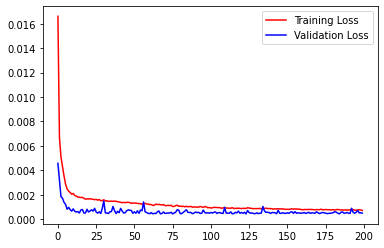

The Mean Squared Error is: 6.021731217632003


In [14]:
try:
    os.chdir(os.path.join(dest,'LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('LSTM')
    os.chdir(os.path.join(dest,'LSTM'))
    print('New Directory Created')

history = atten_lstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_lstm.load_weights(filepath_attention)
preds = atten_lstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)

wk.save(f'LSTM Result.xls')

## CNN-LSTM

In [31]:
## Creating the prelimaries 

filepath_simple = 'simple_cnnlstm.hdf5'
filepath_attention = 'attention_cnnlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [32]:
K.clear_session()
simple_cnnlstm = keras.Sequential()
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
simple_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
simple_cnnlstm.add(keras.layers.Flatten())
simple_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
simple_cnnlstm.add(keras.layers.Dense(32))
simple_cnnlstm.add(keras.layers.Dense(6))

simple_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [37]:
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

# history = simple_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

simple_cnnlstm.load_weights(filepath_simple)
preds = simple_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
The Mean Squared Error is: 7.532575327078259


In [34]:
## Attention model

K.clear_session()
atten_cnnlstm = keras.Sequential()
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3, input_shape=(x_train.shape[1],x_train.shape[2])))
atten_cnnlstm.add(keras.layers.Conv1D(64, kernel_size=3))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(keras.layers.LSTM(64, return_sequences=True))
atten_cnnlstm.add(attention(return_sequences=True))
atten_cnnlstm.add(keras.layers.Flatten())
atten_cnnlstm.add(keras.layers.Dense(512, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(128, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(64, activation='relu'))
atten_cnnlstm.add(keras.layers.Dense(32))
atten_cnnlstm.add(keras.layers.Dense(6))

atten_cnnlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

In [38]:
try:
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('CNN-LSTM')
    os.chdir(os.path.join(dest,'CNN-LSTM'))
    print('New Directory Created')

# history = atten_cnnlstm.fit(x_train,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

# plt.plot(history.history['loss'],'r',label='Training Loss')
# plt.plot(history.history['val_loss'],'b',label='Validation Loss')
# plt.legend()
# plt.show()

atten_cnnlstm.load_weights(filepath_attention)
preds = atten_cnnlstm.predict(x_test)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('CNN-LStM Results.xls')

Directory present
The Mean Squared Error is: 6.202507857381984


## ConvLSTM Model

In [39]:
## Creating the prelimaries 

filepath_simple = 'simple_convlstm.hdf5'
filepath_attention = 'attention_convlstm.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [40]:
x_train_conv =x_train.reshape(x_train.shape[0], 1, 1, x_train.shape[1], x_train.shape[2])
x_test_conv = x_test.reshape(x_test.shape[0], 1, 1, x_test.shape[1], x_test.shape[2])

In [41]:
K.clear_session()
simple_convlstm = keras.Sequential()
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
simple_convlstm.add(keras.layers.Flatten())
simple_convlstm.add(keras.layers.Dense(512, activation='relu'))
simple_convlstm.add(keras.layers.Dense(128, activation='relu'))
simple_convlstm.add(keras.layers.Dense(64, activation='relu'))
simple_convlstm.add(keras.layers.Dense(32))
simple_convlstm.add(keras.layers.Dense(6))

simple_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Creating a new directory......
New Directory Created
Epoch 1/200
245/245 [==============================] - 7s 28ms/step - loss: 0.0359 - mae: 0.1351 - val_loss: 0.0068 - val_mae: 0.0649
Epoch 2/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0081 - mae: 0.0669 - val_loss: 0.0038 - val_mae: 0.0475
Epoch 3/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0060 - mae: 0.0571 - val_loss: 0.0029 - val_mae: 0.0415
Epoch 4/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0050 - mae: 0.0521 - val_loss: 0.0027 - val_mae: 0.0400
Epoch 5/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0047 - mae: 0.0501 - val_loss: 0.0025 - val_mae: 0.0383
Epoch 6/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0043 - mae: 0.0480 - val_loss: 0.0024 - val_mae: 0.0379
Epoch 7/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0041 - mae: 0.0464 - val_loss: 0.0024 - val_mae: 0.0375
Epoch 8/2

245/245 [==============================] - 6s 26ms/step - loss: 7.4697e-04 - mae: 0.0187 - val_loss: 4.7457e-04 - val_mae: 0.0162
Epoch 118/200
245/245 [==============================] - 6s 25ms/step - loss: 7.4423e-04 - mae: 0.0188 - val_loss: 4.8742e-04 - val_mae: 0.0167
Epoch 119/200
245/245 [==============================] - 6s 26ms/step - loss: 7.2822e-04 - mae: 0.0184 - val_loss: 5.0125e-04 - val_mae: 0.0171
Epoch 120/200
245/245 [==============================] - 6s 26ms/step - loss: 7.4187e-04 - mae: 0.0187 - val_loss: 4.6274e-04 - val_mae: 0.0159
Epoch 121/200
245/245 [==============================] - 6s 25ms/step - loss: 7.1486e-04 - mae: 0.0182 - val_loss: 5.1415e-04 - val_mae: 0.0175
Epoch 122/200
245/245 [==============================] - 6s 26ms/step - loss: 7.1060e-04 - mae: 0.0183 - val_loss: 4.4506e-04 - val_mae: 0.0157
Epoch 123/200
245/245 [==============================] - 6s 25ms/step - loss: 7.2081e-04 - mae: 0.0184 - val_loss: 5.6579e-04 - val_mae: 0.0183
Epoch 

Epoch 174/200
245/245 [==============================] - 6s 25ms/step - loss: 5.2792e-04 - mae: 0.0160 - val_loss: 4.8338e-04 - val_mae: 0.0165
Epoch 175/200
245/245 [==============================] - 6s 25ms/step - loss: 5.1806e-04 - mae: 0.0159 - val_loss: 5.7835e-04 - val_mae: 0.0184
Epoch 176/200
245/245 [==============================] - 6s 25ms/step - loss: 5.1508e-04 - mae: 0.0159 - val_loss: 4.6533e-04 - val_mae: 0.0159
Epoch 177/200
245/245 [==============================] - 6s 25ms/step - loss: 5.0047e-04 - mae: 0.0156 - val_loss: 5.3472e-04 - val_mae: 0.0174
Epoch 178/200
245/245 [==============================] - 6s 25ms/step - loss: 4.9805e-04 - mae: 0.0157 - val_loss: 5.1514e-04 - val_mae: 0.0170
Epoch 179/200
245/245 [==============================] - 6s 25ms/step - loss: 5.1483e-04 - mae: 0.0159 - val_loss: 5.7880e-04 - val_mae: 0.0188
Epoch 180/200
245/245 [==============================] - 6s 25ms/step - loss: 4.9777e-04 - mae: 0.0156 - val_loss: 4.8466e-04 - val_mae:

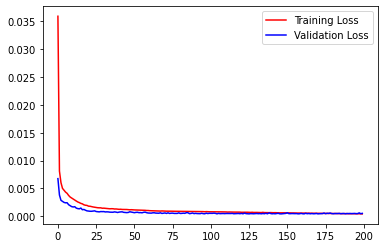

The Mean Squared Error is: 6.56104040864042


In [42]:
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = simple_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_convlstm.load_weights(filepath_simple)
preds = simple_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


In [45]:
K.clear_session()
atten_convlstm = keras.Sequential()
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True, 
                                            input_shape=(x_train_conv.shape[1], x_train_conv.shape[2], 
                                                         x_train_conv.shape[3], x_train_conv.shape[4])))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(keras.layers.ConvLSTM2D(64, kernel_size=(1,3),return_sequences=True))
atten_convlstm.add(attention(return_sequences=True))
atten_convlstm.add(keras.layers.Flatten())
atten_convlstm.add(keras.layers.Dense(512, activation='relu'))
atten_convlstm.add(keras.layers.Dense(128, activation='relu'))
atten_convlstm.add(keras.layers.Dense(64, activation='relu'))
atten_convlstm.add(keras.layers.Dense(32))
atten_convlstm.add(keras.layers.Dense(6))

atten_convlstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

Directory present
Epoch 1/200
245/245 [==============================] - 7s 27ms/step - loss: 0.0326 - mae: 0.1290 - val_loss: 0.0057 - val_mae: 0.0584
Epoch 2/200
245/245 [==============================] - 6s 26ms/step - loss: 0.0080 - mae: 0.0666 - val_loss: 0.0034 - val_mae: 0.0441
Epoch 3/200
245/245 [==============================] - 6s 25ms/step - loss: 0.0055 - mae: 0.0541 - val_loss: 0.0027 - val_mae: 0.0398
Epoch 4/200
245/245 [==============================] - 6s 25ms/step - loss: 0.0048 - mae: 0.0507 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 5/200
245/245 [==============================] - 6s 25ms/step - loss: 0.0044 - mae: 0.0482 - val_loss: 0.0025 - val_mae: 0.0391
Epoch 6/200
245/245 [==============================] - 6s 25ms/step - loss: 0.0041 - mae: 0.0466 - val_loss: 0.0022 - val_mae: 0.0360
Epoch 7/200
245/245 [==============================] - 6s 25ms/step - loss: 0.0038 - mae: 0.0446 - val_loss: 0.0021 - val_mae: 0.0348
Epoch 8/200
245/245 [=======================

245/245 [==============================] - 6s 25ms/step - loss: 6.8980e-04 - mae: 0.0181 - val_loss: 4.7038e-04 - val_mae: 0.0161
Epoch 118/200
245/245 [==============================] - 6s 26ms/step - loss: 6.8534e-04 - mae: 0.0180 - val_loss: 6.3841e-04 - val_mae: 0.0204
Epoch 119/200
245/245 [==============================] - 7s 28ms/step - loss: 6.8823e-04 - mae: 0.0181 - val_loss: 4.8989e-04 - val_mae: 0.0166
Epoch 120/200
245/245 [==============================] - 7s 27ms/step - loss: 6.6431e-04 - mae: 0.0176 - val_loss: 4.6032e-04 - val_mae: 0.0157
Epoch 121/200
245/245 [==============================] - 6s 26ms/step - loss: 6.7272e-04 - mae: 0.0178 - val_loss: 4.5018e-04 - val_mae: 0.0160
Epoch 122/200
245/245 [==============================] - 6s 25ms/step - loss: 6.6272e-04 - mae: 0.0176 - val_loss: 4.8111e-04 - val_mae: 0.0162
Epoch 123/200
245/245 [==============================] - 6s 26ms/step - loss: 6.5517e-04 - mae: 0.0175 - val_loss: 5.1477e-04 - val_mae: 0.0173
Epoch 

Epoch 174/200
245/245 [==============================] - 6s 25ms/step - loss: 4.4509e-04 - mae: 0.0148 - val_loss: 5.5367e-04 - val_mae: 0.0172
Epoch 175/200
245/245 [==============================] - 6s 25ms/step - loss: 4.4877e-04 - mae: 0.0149 - val_loss: 4.7291e-04 - val_mae: 0.0159
Epoch 176/200
245/245 [==============================] - 6s 25ms/step - loss: 4.5330e-04 - mae: 0.0150 - val_loss: 4.8631e-04 - val_mae: 0.0163
Epoch 177/200
245/245 [==============================] - 6s 25ms/step - loss: 4.4204e-04 - mae: 0.0148 - val_loss: 4.6683e-04 - val_mae: 0.0160
Epoch 178/200
245/245 [==============================] - 6s 25ms/step - loss: 4.4076e-04 - mae: 0.0147 - val_loss: 5.6421e-04 - val_mae: 0.0178
Epoch 179/200
245/245 [==============================] - 6s 25ms/step - loss: 4.3785e-04 - mae: 0.0147 - val_loss: 4.6669e-04 - val_mae: 0.0161
Epoch 180/200
245/245 [==============================] - 6s 25ms/step - loss: 4.4167e-04 - mae: 0.0148 - val_loss: 4.9162e-04 - val_mae:

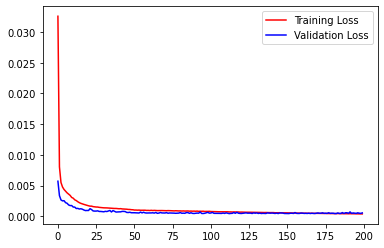

The Mean Squared Error is: 6.031831646131014


In [46]:
try:
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('ConvLSTM')
    os.chdir(os.path.join(dest,'ConvLSTM'))
    print('New Directory Created')

history = atten_convlstm.fit(x_train_conv,y_train,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_attention])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

atten_convlstm.load_weights(filepath_attention)
preds = atten_convlstm.predict(x_test_conv)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet2.write(0, 0, 'MSE')
        sheet2.write(0, 1, 'Hours Ahead')
        sheet2.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet2.write(i + 1, 1, i+1)
wk.save('ConvLSTM Results.xls')

## Seq2Seq Model

In [5]:
## Creating the prelimaries 

filepath_simple = 'simple_seq2seq.hdf5'
filepath_attention = 'attention_seq2seq.hdf5'

checkpoint_simple = keras.callbacks.ModelCheckpoint(filepath_simple,monitor='val_loss',save_best_only=True)
checkpoint_attention = keras.callbacks.ModelCheckpoint(filepath_attention, monitor='val_loss',save_best_only=True)

wk=Workbook()
sheet1 = wk.add_sheet('Simple', cell_overwrite_ok=True)
sheet2 = wk.add_sheet('Attention', cell_overwrite_ok=True)
sheet3 = wk.add_sheet('Predictions', cell_overwrite_ok=True)

In [6]:
y_train_seq = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [7]:
K.clear_session()
input_train = keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
output_train = keras.layers.Input(shape=(y_train_seq.shape[1], y_train_seq.shape[2]))

## Encoder Section##
encoder_first = keras.layers.LSTM(256, return_sequences=True, return_state=False)(input_train)
encoder_second = keras.layers.LSTM(256, return_sequences=True)(encoder_first)
encoder_third = keras.layers.LSTM(256, return_sequences=True)(encoder_second)
encoder_fourth, encoder_fourth_s1, encoder_fourth_s2 = keras.layers.LSTM(256,return_sequences=False, return_state=True)(encoder_third)

##Decorder Section##
decoder_first = keras.layers.RepeatVector(output_train.shape[1])(encoder_fourth)
decoder_second = keras.layers.LSTM(256, return_state=False, return_sequences=True)(decoder_first,initial_state=[encoder_fourth,encoder_fourth_s2])
decoder_third = keras.layers.LSTM(256,return_sequences=True)(decoder_second)
decoder_fourth = keras.layers.LSTM(256,return_sequences=True)(decoder_third)
decoder_fifth = keras.layers.LSTM(256,return_sequences=True)(decoder_fourth)
print(decoder_fifth)

##Output Section##
output = keras.layers.TimeDistributed(keras.layers.Dense(output_train.shape[2]))(decoder_fifth)

simple_seq = keras.Model(inputs=input_train, outputs=output)
opt = keras.optimizers.Adam(learning_rate=0.001)
simple_seq.compile(loss='mse', optimizer=opt, metrics=['mae'])
simple_seq.summary()

Tensor("lstm_7/PartitionedCall:1", shape=(None, 6, 256), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 2)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 24, 256)      265216      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 24, 256)      525312      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 24, 256)      525312      lstm_1[0][0]                     
_______________

In [ ]:
try:
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('Directory present')
except FileNotFoundError:
    print('Creating a new directory......')
    os.chdir(os.path.join(dest))
    os.mkdir('Seq2Seq')
    os.chdir(os.path.join(dest,'Seq2Seq'))
    print('New Directory Created')

history = simple_seq.fit(x_train,y_train_seq,validation_split=0.1,batch_size=32,epochs=200,callbacks=[checkpoint_simple])

plt.plot(history.history['loss'],'r',label='Training Loss')
plt.plot(history.history['val_loss'],'b',label='Validation Loss')
plt.legend()
plt.show()

simple_seq.load_weights(filepath_simple)
preds = simple_seq.predict(x_test)

preds = preds.reshape(preds.shape[0],preds.shape[1])
print(preds.shape)

y_test_unscaled = scaler.inverse_transform(y_test)
y_pred_unscaled = scaler.inverse_transform(preds)

e_mse = mse(y_test_unscaled[:,5],y_pred_unscaled[:,5])
print(f'The Mean Squared Error is: {e_mse}')

for i in range(y_test.shape[1]):
        sheet1.write(0, 0, 'MSE')
        sheet1.write(0, 1, 'Hours Ahead')
        sheet1.write(i + 1, 0, mse(y_test_unscaled[:,i],y_pred_unscaled[:,i]))
        sheet1.write(i + 1, 1, i+1)


Directory present
Epoch 1/200
245/245 [==============================] - 5s 21ms/step - loss: 0.0174 - mae: 0.0915 - val_loss: 0.0036 - val_mae: 0.0485
Epoch 2/200
245/245 [==============================] - 4s 16ms/step - loss: 0.0059 - mae: 0.0574 - val_loss: 0.0023 - val_mae: 0.0377
Epoch 3/200
245/245 [==============================] - 4s 16ms/step - loss: 0.0042 - mae: 0.0478 - val_loss: 0.0018 - val_mae: 0.0337
Epoch 4/200
245/245 [==============================] - 4s 15ms/step - loss: 0.0027 - mae: 0.0377 - val_loss: 8.9547e-04 - val_mae: 0.0235
Epoch 5/200
245/245 [==============================] - 4s 15ms/step - loss: 0.0019 - mae: 0.0304 - val_loss: 7.3106e-04 - val_mae: 0.0211
Epoch 6/200
245/245 [==============================] - 4s 14ms/step - loss: 0.0016 - mae: 0.0281 - val_loss: 0.0010 - val_mae: 0.0256
Epoch 7/200
245/245 [==============================] - 4s 15ms/step - loss: 0.0014 - mae: 0.0268 - val_loss: 5.8406e-04 - val_mae: 0.0183
Epoch 8/200
245/245 [===========

245/245 [==============================] - 4s 15ms/step - loss: 4.9400e-04 - mae: 0.0160 - val_loss: 5.0106e-04 - val_mae: 0.0149
Epoch 59/200
245/245 [==============================] - 4s 15ms/step - loss: 4.4798e-04 - mae: 0.0153 - val_loss: 5.1593e-04 - val_mae: 0.0155
Epoch 60/200
245/245 [==============================] - 4s 15ms/step - loss: 4.3620e-04 - mae: 0.0150 - val_loss: 4.2631e-04 - val_mae: 0.0154
Epoch 61/200
245/245 [==============================] - 4s 15ms/step - loss: 4.6057e-04 - mae: 0.0156 - val_loss: 5.2488e-04 - val_mae: 0.0159
Epoch 62/200
245/245 [==============================] - 4s 15ms/step - loss: 4.1057e-04 - mae: 0.0147 - val_loss: 4.8558e-04 - val_mae: 0.0160
Epoch 63/200
245/245 [==============================] - 4s 15ms/step - loss: 4.7242e-04 - mae: 0.0157 - val_loss: 5.2065e-04 - val_mae: 0.0154
Epoch 64/200
245/245 [==============================] - 4s 15ms/step - loss: 4.5997e-04 - mae: 0.0156 - val_loss: 4.8114e-04 - val_mae: 0.0146
Epoch 65/200